In [15]:
from transformers import AutoTokenizer, AutoModel
import torch
from IPython.display import clear_output
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset, load_dataset, load_from_disk
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from evaluate import load
import datetime
import os
import numpy as np
# from sklearn.model_selection import train_test_split


In [2]:
# source: https://github.com/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb
# export HF_HOME=/sci/archive/michall/roeizucker/huggingface_modles_cache
# set HF_HOME=/sci/archive/michall/roeizucker/huggingface_modles_cache

In [23]:
# kernel = np.array([
#     [1,1,1],
#     [0,0,0],
#     [1,1,1]
# ])

# board =np.array( [[0, 0, 0, 1, 0, 0],
#     			[0, 0, 0, 1, 0, 0],
# 		    	[0, 1, 1, 0, 1, 0],
#     			[0, 0, 0, 1, 0, 0],
#     			[0, 0, 0, 1, 0, 0],
#     			[0, 0, 0, 0, 0, 0]])

# height,width =board.shape[0],board.shape[1]

# # Get the height, width, and number of channels of the kernel
# kernel_height,kernel_width = kernel.shape[0],kernel.shape[1]

# # Create a new image of original img size minus the border 
# # where the convolution can't be applied
# new_img = np.zeros((height-kernel_height+1,width-kernel_width+1,3)) 

# # Loop through each pixel in the image
# # But skip the outer edges of the image
# for i in range(kernel_height//2, height-kernel_height//2-1):
#     for j in range(kernel_width//2, width-kernel_width//2-1):
#         # Extract a window of pixels around the current pixel
#         window = board[i-kernel_height//2 : i+kernel_height//2+1,j-kernel_width//2 : j+kernel_width//2+1]
#         print(window)
#         print(window*kernel)
#         print("****")

In [29]:
print("test")

test


In [19]:
TARGETSCAN_DATASET_PATH = "/sci/nosnap/michall/roeizucker/token_classification/targetscan_RNA_combined_nrows_90000_hg38.csv"
KMER_SIZE = 6
model_name = "InstaDeepAI/nucleotide-transformer-500m-1000g"
MAX_TOKEN = 1000
BLANK_LABLE_VALUE = -100
ADD_BLANKS_TO_END = False
TRAIN_AMOUNT = 0.5
AMOUNT_OF_ZEROS_TO_IGNORE = 0.975
EPOCH_NUM = 10
METRIC = "None"

In [5]:
# model.config.features

In [20]:
# spliceAI data:
TRAIN_DF_PATH = "/sci/nosnap/michall/roeizucker/token_classification/spliceai_train.csv"
TEST_DF_PATH = "/sci/nosnap/michall/roeizucker/token_classification/spliceai_test.csv"
train_df = pd.read_csv(TRAIN_DF_PATH)
test_df = pd.read_csv(TEST_DF_PATH)
SPLICEAI_LABLES = ["none","start","end"]
SPLICE_AI = True
# 

In [4]:
# train_df

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [6]:
def convert_list_representation_to_list(df,seq_col_name="sequnces",labels_col_name="labels"):
    df["result"] = df[seq_col_name].str.replace("'","")
    df["result"] = df["result"].apply(lambda x:x.strip('][').split(', '))
    df["stags"] = df[labels_col_name].apply(lambda x:x.strip('][').replace("'","").split(', '))
    df['stags'] = df['stags'].apply(lambda x: list(map(SPLICEAI_LABLES.index, x)))
    return df
def create_sequnces_from_df(df):
    sequences = []
    labels = []
    for row_idx, row in df.iterrows():
        if row_idx % 100 == 0:
            clear_output(wait=True)
            # print(filename.split("/")[-1])
            print(str(int(100*(row_idx / len(df)))) + "%")

        curr_label = []
        for i, seq in enumerate(row["result"]):
            curr_label.extend([row["stags"][i]]*len(seq))
        
        label = np.zeros(len(curr_label)//KMER_SIZE,dtype=np.int64)
        for i in range(0,len(curr_label),KMER_SIZE):
            # if i+KMER_SIZE <len(curr_label) and 1 in curr_label[i:i+KMER_SIZE]) :
            #     label[i//KMER_SIZE:i//6+1] = 1
            
            for j in range(1,len(SPLICEAI_LABLES)):
                if i+KMER_SIZE <len(curr_label) and j in curr_label[i:i+KMER_SIZE]:
                    label[i//KMER_SIZE:i//KMER_SIZE+1] = j
                    break
            else: # unneeded
                label[i//KMER_SIZE:i//KMER_SIZE+1] = 0
        seq_str = "".join(row["result"])[:len(curr_label)]
        last_i = 0
        
        for i in range(0,len(label) - MAX_TOKEN,MAX_TOKEN):
            if sum(label[i:i+MAX_TOKEN]) == 0:
                last_i = i
                continue
            sequences.append(seq_str[i*6:(i+MAX_TOKEN)*6])
            labels.append(label[i:i+MAX_TOKEN])
            last_i = i
        if ADD_BLANKS_TO_END:
            sequences.append(seq_str[last_i*6:])
            
            labels.append(np.concatenate(
                [label[last_i:] ,  
                np.array(
                    [BLANK_LABLE_VALUE]* 
                    (MAX_TOKEN - len(label[last_i:])))]))
    return sequences, labels
def create_datasets(seq,labels):
    train_sequences, test_sequences, train_labels, test_labels = train_test_split(seq, labels, test_size=0.25, shuffle=False)
    
    train_tokenized = tokenizer(
        train_sequences,
        max_length=1000,
        padding='max_length',
        truncation=True
    )
    
    test_tokenized = tokenizer(
        test_sequences,
        max_length=1000,
        padding='max_length',
        truncation=True
    )
    train_dataset = Dataset.from_dict(train_tokenized)
    test_dataset = Dataset.from_dict(test_tokenized)
    
    train_dataset = train_dataset.add_column("labels", train_labels)
    test_dataset = test_dataset.add_column("labels", test_labels)
    return train_dataset,test_dataset

In [9]:
# list(train_df.head(1)["stags"])

In [16]:
if not os.path.exists("train.hf") and not os.path.exists("test.hf"):
    if SPLICE_AI == True:
        train_df = convert_list_representation_to_list(train_df)
        test_df = convert_list_representation_to_list(test_df)
        
    train_seq, train_labels = create_sequnces_from_df(train_df)
    # ignore some of the 0 values
    if AMOUNT_OF_ZEROS_TO_IGNORE!= 0:
        for i in range(len(train_labels)):
            sequence_labels = train_labels[i]
            # for sequence_labels in train_labels:
            zero_indices = np.where(sequence_labels == 0)[0]
    
            # Calculate the number of zeros to replace based on AMOUNT_OF_ZEROS_TO_IGNORE
            num_zeros_to_replace = int(AMOUNT_OF_ZEROS_TO_IGNORE * len(zero_indices))
            
            # Randomly choose the specified percentage of zero indices
            indices_to_replace = np.random.choice(zero_indices, num_zeros_to_replace, replace=False)
            
            # Replace those values with -100
            sequence_labels[indices_to_replace] = -100
    
            train_labels[i] = sequence_labels
    train_seq = train_seq[:int(len(train_seq) * TRAIN_AMOUNT)]
    train_labels = train_labels[:int(len(train_labels) * TRAIN_AMOUNT)]
    train_dataset,test_dataset = create_datasets(train_seq, train_labels)
    train_dataset.save_to_disk("train.hf")
    test_dataset.save_to_disk("test.hf")

    # train_dataset.to_csv("curr_train_dataset.csv")
    # test_dataset.to_csv("curr_test_dataset.csv")
else:
    train_dataset = load_from_disk("train.hf")
    test_dataset = load_from_disk("test.hf")

    # train_dataset = Dataset.from_dict(load_dataset("csv", data_files="curr_train_dataset.csv"))
    # test_dataset = Dataset.from_dict(load_dataset("csv", data_files="curr_test_dataset.csv"))
    
    # train_dataset = Dataset.from_csv("curr_train_dataset.csv")
    # test_dataset = Dataset.from_csv("curr_test_dataset.csv")

In [8]:
dic = {}
for i in range(len(train_dataset)):
    if i % 100 == 0:
            clear_output(wait=True)
            print(str(int(100*(i / len(train_dataset)))) + "%")
    for val in train_dataset[i]["labels"]:
        if val not in dic:
            dic[val] = 0
        dic[val]+= 1


99%


In [9]:
for label in dic:
    print(f"{label} label:",dic[label])

-100 label: 23415074
0 label: 603084
1 label: 55870
2 label: 49972


In [13]:
# os.path.exists("curr_train_dataset.csv")

In [10]:
def create_model():
    model = AutoModelForTokenClassification.from_pretrained(model_name,num_labels=len(SPLICEAI_LABLES), device_map="auto")
    return model
model = create_model()
data_collator = DataCollatorForTokenClassification(tokenizer)

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-1000g and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
batch_size = 1
# TODO: USE their parameters and LORA. copy from them
args = TrainingArguments(
    f"{model_name}-finetuned-secondary-structure",
    evaluation_strategy = "no",
    eval_strategy = "no",
    do_eval=False,
    # evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=EPOCH_NUM,
    weight_decay=0.001,
    # load_best_model_at_end=True,
    metric_for_best_model=METRIC,
    push_to_hub=False,
)

/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# metric.compute(predictions=np.array([[0,0,0]]), references=np.array([[0,0,0]]))

In [12]:
from evaluate import load, combine
import numpy as np
if METRIC != "None":
    metric = load(METRIC)
    clf_metrics = combine(["accuracy", "f1", "precision", "recall"])
master_dict = {}
def compute_metrics(eval_pred):
    # logits, labels = eval_pred
    # predictions = np.argmax(logits, axis=-1)
    # return metric.compute(predictions=predictions, references=labels)

    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=BLANK_LABLE_VALUE]
    labels = labels[labels!=BLANK_LABLE_VALUE]

    master_dict["predictiosn"] = predictions
    master_dict["references"] = labels
    return metric.compute(predictions=predictions, references=labels,average="weighted")
    # return {"recall":metric.compute(predictions=master_dict["predictiosn"],references=master_dict["references"],average=None)["recall"][1:].mean()}
    # return clf_metrics.compute(predictions=predictions, references=labels,average="weighted")
    

In [18]:
# metric.compute(predictions=master_dict["predictiosn"], references=master_dict["references"],average=None)

In [19]:
# master_dict["references"]
# assert(False)



In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()
# assert(False)

# trainer.train(resume_from_checkpoint="/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-secondary-structure/checkpoint-96498")
# assert(False)

/tmp/ipykernel_1063831/845390017.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.512100
1000,0.513800
1500,0.500800
2000,0.499500
2500,0.509400
3000,0.489700
3500,0.505300
4000,0.500600
4500,0.498400
5000,0.503600


In [ ]:
model_name = f"spliceAI_NT_0.1_{str(datetime.datetime.now())}_{EPOCH_NUM}_{METRIC}_{TRAIN_AMOUNT}_{AMOUNT_OF_ZEROS_TO_IGNORE}"

In [ ]:
trainer.save_model(model_name)

In [ ]:
trainer.state.log_history[-0]

In [31]:
print("Done")

Done


In [ ]:
str(datetime.datetime.now())

In [11]:
def compute_metrics(eval_pred):
    # logits, labels = eval_pred
    # predictions = np.argmax(logits, axis=-1)
    # return metric.compute(predictions=predictions, references=labels)

    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=BLANK_LABLE_VALUE]
    labels = labels[labels!=BLANK_LABLE_VALUE]

    master_dict["predictiosn"] = predictions
    master_dict["references"] = labels
    return metric.compute(predictions=predictions, references=labels,average="weighted")


In [12]:
def show_for_num(num,dataset,trainer):
    predict_dataset = Dataset.from_dict(dataset[num:num+1])
    if (len(predict_dataset[0]["labels"])) != MAX_TOKEN:
        return []
    # input()
    raw_pred, _, _ = trainer.predict(predict_dataset)
    y_pred = np.argmax(raw_pred, axis=2)
    counter = 0
    flag = False
    res = []
    for pred,orig in zip(y_pred[0],np.array(dataset[num]["labels"])):
        if orig==-100:
            break
        if pred != 0 or orig != 0:
        # if pred != 0:
            flag = True
            # print(num,pred,orig,counter)
            res.append((num,pred,orig,counter))
        counter+=1
    return res
    # if flag:
    #     print("*******"*11)
# results = []
# for i in range(0,500):
#     # print(i)
#     print(i)
#     results.extend(show_for_num(i,test_dataset,trainer))
# results
# show_for_num(17,train_dataset)

In [15]:
len(train_dataset[33]["labels"])

1000

In [ ]:
# i = 8
for i in range(len(results)):
    if results[i][1] !=0 and results[i][2] !=0:
        print(results[i])
len(results)

In [ ]:
predict_dataset = Dataset.from_dict(test_dataset[0:1])
raw_pred, _, _ = trainer.predict(predict_dataset)
y_pred = np.argmax(raw_pred, axis=2)
# print(y_pred[0])
# print(np.array(test_dataset[num]["labels"]))
counter = 8
for pred,orig in zip(y_pred[0],np.array(test_dataset[counter]["labels"])):
    if orig==-100:
        break
    if orig!=0 or pred != 0:
        print(pred,orig,counter)
    counter+=1

In [ ]:
assert(False)

In [ ]:
# # try to load:
# model1 = AutoModelForTokenClassification.from_pretrained("/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-secondary-structure/checkpoint-89272")
# model2 = AutoModelForTokenClassification.from_pretrained("/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-secondary-structure/checkpoint-100431")
# model3 = AutoModelForTokenClassification.from_pretrained("/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-secondary-structure/checkpoint-111590")
# # trainer.train(resume_from_checkpoint="/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-secondary-structure/checkpoint-89272")

In [ ]:
# trainer1= Trainer(
#     model=model1,args=args
# )
# trainer2= Trainer(
#     model=model2,args=args
# )
# trainer3= Trainer(
#     model=model3,args=args
# )


In [ ]:


# for trainer in trainers:
#     calc_for_num(trainer)

In [ ]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=data_collator,
# )

# trainer.train()

In [13]:

local_metric = load("accuracy")

def calc_for_num(trainer,dataset,count):
    curr_res = []
    for i in range(count):
        curr_res.extend(show_for_num(i,dataset,trainer))
    return curr_res

def delete_me(eval_pred):
    # print(eval_pred)
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return local_metric.compute(predictions=predictions, references=labels)

def local_compute_metrics_avaraged(eval_pred,local_metric):
    # print(eval_pred)
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return local_metric.compute(predictions=predictions, references=labels,average=None)

def local_compute_metrics_non_avaraged(eval_pred,local_metric):
    # print(eval_pred)
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return local_metric.compute(predictions=predictions, references=labels)

def do_multiple_evals(regular_metrics,avaraged_metrics,model,dataset):
    res = {}
    for metric,name in regular_metrics:
        try:
            trainer = Trainer(model,args,compute_metrics=lambda eval_pred: local_compute_metrics_non_avaraged(eval_pred,metric))
            res[name] = trainer.evaluate(Dataset.from_dict(dataset[0:count]))
            # del trainer
        finally:
            del trainer
    for metric,name in avaraged_metrics:
        try:
            trainer = Trainer(model,args,compute_metrics=lambda eval_pred: local_compute_metrics_avaraged(eval_pred,metric))
            res[name] = trainer.evaluate(Dataset.from_dict(dataset[0:count]))
        finally:
            del trainer
    return res

In [22]:
final_results = []
eval_results = []
dir_names = []
avaraged_metrics = [(load("f1"),"f1"),(load("recall"),"recall"),(load("precision"),"precision")]
regular_metrics = [(load("accuracy"),"accuracy")]
checkpoints_path = "/sci/nosnap/michall/roeizucker/jupyter_notebooks/Tom_Hope_Project/InstaDeepAI/nucleotide-transformer-500m-1000g-finetuned-secondary-structure/"

count = 250
# dataset = train_dataset


dataset_num = 0
dataset_names = ["train","test"]
for dataset in [train_dataset,test_dataset]:
    for dir_name in os.listdir(checkpoints_path):
        if "checkpoint" in dir_name:
            dir_names.append(dir_name + "_" +dataset_names[dataset_num])
            print(dir_name + "_" +dataset_names[dataset_num])
            try:
                # print(os.path.join(checkpoints_path,dir_name))
                curr_model = AutoModelForTokenClassification.from_pretrained(os.path.join(checkpoints_path,dir_name))
                curr_trainer = Trainer(curr_model,args,compute_metrics = delete_me)
                final_results.append(calc_for_num(curr_trainer,dataset,count))
                # eval_results.append(curr_trainer.evaluate(Dataset.from_dict(dataset[0:count]))["eval_f1"])
                eval_results.append(do_multiple_evals(regular_metrics,avaraged_metrics,curr_model,dataset))

            finally:
            # final_results.append()
                del curr_model
                del curr_trainer
    dataset_num+=1



checkpoint-96496_train


Trainer is attempting to log a value of "[0.95415648 0.48210923 0.00611621]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99904    0.32241814 0.00306748]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.91313249 0.95522388 1.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-168868_train


Trainer is attempting to log a value of "[0.98187549 0.87052342 0.72075472]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9968     0.79596977 0.58588957]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9673913  0.96048632 0.93627451]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-144744_train


Trainer is attempting to log a value of "[0.97622028 0.82828283 0.60127932]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9984     0.72292191 0.43251534]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.95500459 0.96959459 0.98601399]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-48248_train


Trainer is attempting to log a value of "[0.94532254 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[1. 0. 0.]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.89631436 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-217116_train


Trainer is attempting to log a value of "[0.99009116 0.93245033 0.84722222]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9992     0.88664987 0.74846626]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9811469  0.98324022 0.976     ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-72372_train


Trainer is attempting to log a value of "[0.94532254 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[1. 0. 0.]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.89631436 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-120620_train


Trainer is attempting to log a value of "[0.96730203 0.73716952 0.35768262]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99872    0.59697733 0.21779141]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.93780048 0.96341463 1.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-192992_train


Trainer is attempting to log a value of "[0.98623853 0.89905787 0.78711986]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9976     0.84130982 0.67484663]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.97513294 0.96531792 0.94420601]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-241240_train


Trainer is attempting to log a value of "[0.99126707 0.94055482 0.87352445]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99888    0.89672544 0.79447853]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9837693  0.98888889 0.97003745]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-24124_train


Trainer is attempting to log a value of "[0.94532254 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[1. 0. 0.]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.89631436 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-96496_test


Trainer is attempting to log a value of "[0.92787204 0.00739372 0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.99312   0.0040404 0.       ]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.8706691  0.04347826 0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-168868_test


Trainer is attempting to log a value of "[0.91225393 0.05420827 0.02568807]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.95648    0.03838384 0.0162413 ]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.87193699 0.09223301 0.06140351]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-144744_test


Trainer is attempting to log a value of "[0.91889032 0.04643963 0.00419287]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.97248    0.03030303 0.00232019]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.87089841 0.09933775 0.02173913]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-48248_test


Trainer is attempting to log a value of "[0.93102935 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[1. 0. 0.]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.87095875 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-217116_test


Trainer is attempting to log a value of "[0.89988368 0.06956522 0.03680982]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.92832    0.05656566 0.02784223]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.8731377  0.09032258 0.05429864]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-72372_test


Trainer is attempting to log a value of "[0.93102935 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[1. 0. 0.]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.87095875 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-120620_test


Trainer is attempting to log a value of "[0.92372499 0.0330033  0.00884956]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9824     0.02020202 0.00464037]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.87166383 0.09009009 0.0952381 ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-192992_test


Trainer is attempting to log a value of "[0.90538462 0.05866667 0.02657807]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9416     0.04444444 0.01856148]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.87185185 0.08627451 0.04678363]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-241240_test


Trainer is attempting to log a value of "[0.89266156 0.06609547 0.04515272]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.9128     0.05454545 0.03944316]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[0.87339253 0.08385093 0.05279503]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


checkpoint-24124_test


Trainer is attempting to log a value of "[0.93102935 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Trainer is attempting to log a value of "[1. 0. 0.]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.87095875 0.         0.        ]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [ ]:

for i in range(len(final_results)):
    good = 0
    bad = 0
    for match in final_results[i]:
        if match[1] == match[2]:
            good+=1
        else:
            bad+=1
    print(dir_names[i])
    print(good,bad)
    for key in eval_results[i]:
        print(key,eval_results[i][key]["eval_"+key])

In [24]:
final_df = pd.DataFrame([dir_names,final_results,eval_results]).T

In [25]:
final_df.columns = ['name', 'res', 'score']


In [26]:
df_name = f"results_0-epoch_{TRAIN_AMOUNT}-ratio-0.9_of_0"


In [ ]:
# final_df["score"][0]

In [27]:
final_df["accuracy_score"] = final_df["score"].apply(lambda x:x["accuracy"]["eval_accuracy"])
final_df["f1_0"] = final_df["score"].apply(lambda x:x["f1"]["eval_f1"][0])
final_df["f1_1"] = final_df["score"].apply(lambda x:x["f1"]["eval_f1"][1])
final_df["f1_2"] = final_df["score"].apply(lambda x:x["f1"]["eval_f1"][2])
final_df["recall_0"] = final_df["score"].apply(lambda x:x["recall"]["eval_recall"][0])
final_df["recall_1"] = final_df["score"].apply(lambda x:x["recall"]["eval_recall"][1])
final_df["recall_2"] = final_df["score"].apply(lambda x:x["recall"]["eval_recall"][2])
final_df["precision_0"] = final_df["score"].apply(lambda x:x["precision"]["eval_precision"][0])
final_df["precision_1"] = final_df["score"].apply(lambda x:x["precision"]["eval_precision"][1])
final_df["precision_2"] = final_df["score"].apply(lambda x:x["precision"]["eval_precision"][2])
final_df.to_csv(df_name)

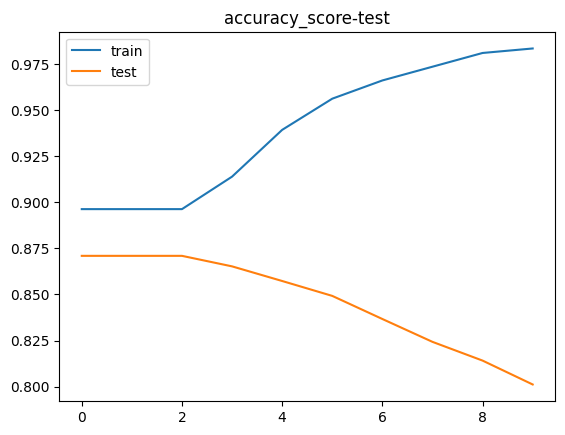

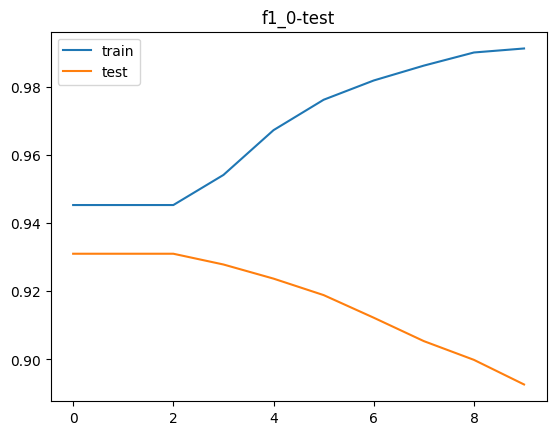

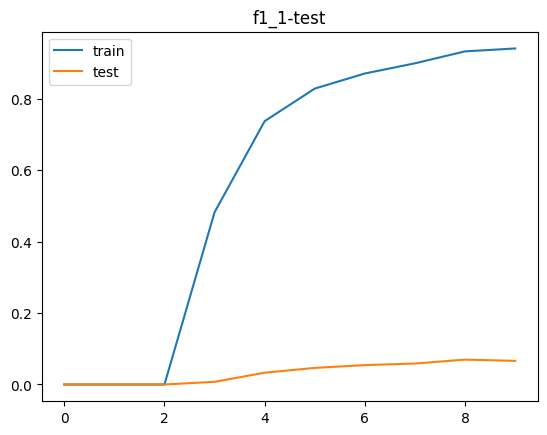

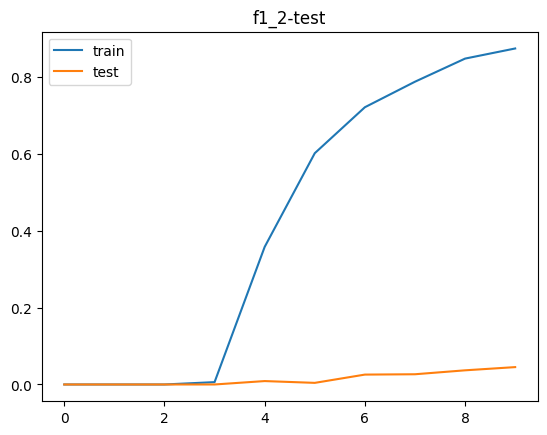

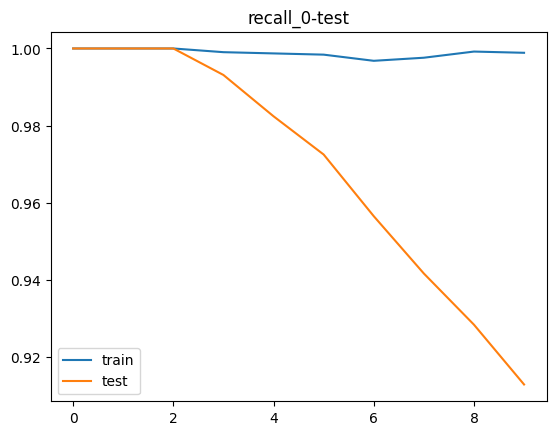

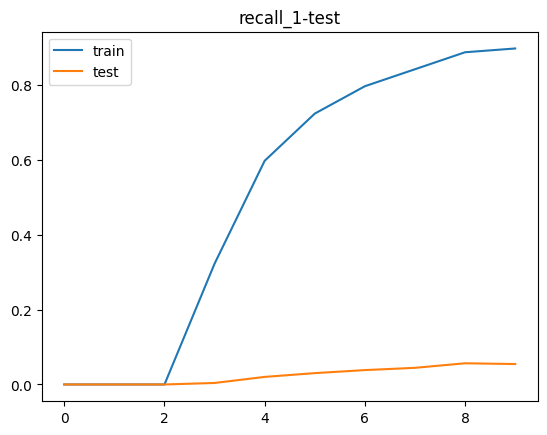

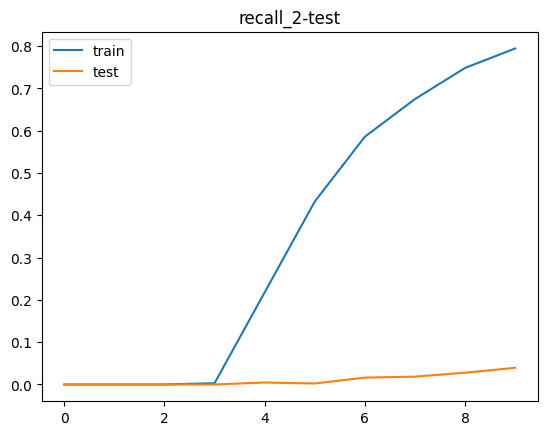

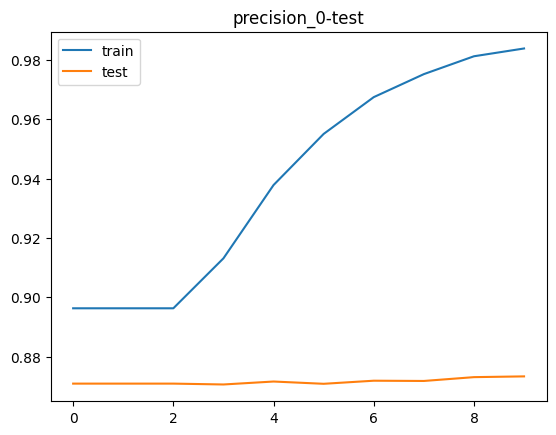

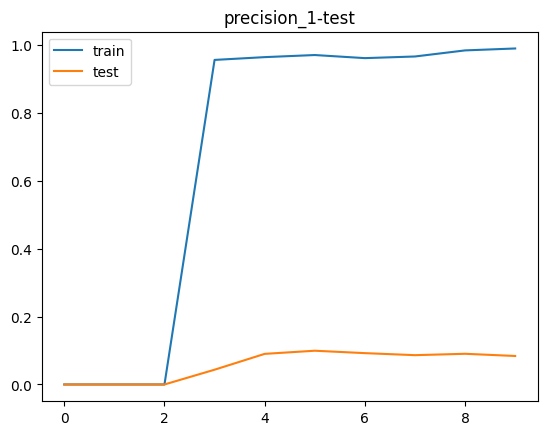

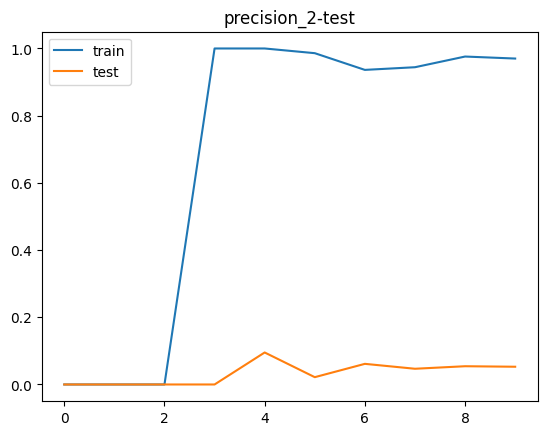

In [28]:
import matplotlib.pyplot as plt
def make_plot(col,suf):
    temp_df = final_df[["name",col]]
    temp_df = temp_df[temp_df["name"].str.endswith(suf)]
    temp_df["step"] = (temp_df["name"].str.replace("checkpoint-","").str.replace("_" + suf,"").astype(int))
    
    temp_df.sort_values(by="step")[[col]].reset_index()[col].plot.line()
    plt.title(col + "-" + suf)
    # plt.show()
skip = False
for score in final_df.columns[3:]:
    make_plot(score,"train")
    make_plot(score,"test")
    plt.legend(["train","test"])
    plt.savefig(f"{score}.png")
    plt.show()


In [ ]:
curr_model = AutoModelForTokenClassification.from_pretrained(os.path.join(checkpoints_path,dir_name))
curr_trainer = Trainer(curr_model,args,compute_metrics=local_compute_metrics)

In [ ]:
del curr_trainer
del curr_model

In [ ]:
curr_trainer.evaluate(Dataset.from_dict(test_dataset[0:10]))["eval_f1"]

In [ ]:
curr_trainer.evaluate(Dataset.from_dict(train_dataset[0:10]))["eval_f1"]

In [ ]:
df = pd.read_csv(TARGETSCAN_DATASET_PATH)

df["result"] = df["result"].str.replace("'","")
df["result"] = df["result"].apply(lambda x:x.strip('][').split(', '))
df["stags"] = df["stags"].apply(lambda x:x.strip('][').split(', '))
df['stags'] = df['stags'].apply(lambda x: list(map(int, x)))


In [ ]:
df.head(3)

In [ ]:
for row_idx, row in df.iterrows():

    curr_label = []
    for i, seq in enumerate(row["result"]):
        curr_label.extend([row["stags"][i]]*len(seq))
    # if len(curr_label) > 6000:
    #     curr_label = curr_label[:5977] # TODO: change so even after the label it's added, split region to multiple spaces
    # if len(curr_label) %6 != 0:
    label = np.zeros(len(curr_label)//6,dtype=np.int64)
    # else:
    #     continue
        
    for i in range(0,len(curr_label),6):
        if i+6 <len(curr_label) and sum(curr_label[i:i+6]) > 1:
            label[i//6:i//6+1] = 1
        else: # unneeded
            label[i//6:i//6+1] = 0
    if len(label) > 1000: #TODO: magic number! this is max length of token
        label = label[:1000]
    if len(label) < 1000:
        label = np.concatenate([label, np.array([-100]* (1000 - len(label)))])
    sequences.append( "".join(row["result"])[:len(curr_label)])
    labels.append(label)

In [ ]:
# # working
# sequences = []
# labels = []

# for row_idx, row in df.iterrows():

#     curr_label = []
#     for i, seq in enumerate(row["result"]):
#         curr_label.extend([row["stags"][i]]*len(seq))
#     if len(curr_label) > 1000:
#         continue
#     if len(curr_label) %6 != 0:
#         label = np.zeros(len(curr_label)//6,dtype=np.int64)
#     else:
#         continue
        
#     for i in range(0,len(curr_label),6):
#         if i+6 <len(curr_label) and sum(curr_label[i:i+6]) > 1:
#             label[i//6:i//6+1] = 1
#         else: # unneeded
#             label[i//6:i//6+1] = 0
#     sequences.append( "".join(row["result"]))
#     labels.append(label)


In [ ]:
# # working 2
# sequences = []
# labels = []

# for row_idx, row in df.iterrows():

#     curr_label = []
#     for i, seq in enumerate(row["result"]):
#         curr_label.extend([row["stags"][i]]*len(seq))
#     if len(curr_label) > 6000:
#         curr_label = curr_label[:5977] # TODO: change so even after the label it's added, split region to multiple spaces
#     if len(curr_label) %6 != 0:
#         label = np.zeros(len(curr_label)//6,dtype=np.int64)
#     else:
#         continue
        
#     for i in range(0,len(curr_label),6):
#         if i+6 <len(curr_label) and sum(curr_label[i:i+6]) > 1:
#             label[i//6:i//6+1] = 1
#         else: # unneeded
#             label[i//6:i//6+1] = 0
#     sequences.append( "".join(row["result"])[:len(curr_label)])
#     labels.append(label)


In [ ]:
# working
sequences = []
labels = []

for row_idx, row in df.iterrows():

    curr_label = []
    for i, seq in enumerate(row["result"]):
        curr_label.extend([row["stags"][i]]*len(seq))
    # if len(curr_label) > 6000:
    #     curr_label = curr_label[:5977] # TODO: change so even after the label it's added, split region to multiple spaces
    # if len(curr_label) %6 != 0:
    label = np.zeros(len(curr_label)//6,dtype=np.int64)
    # else:
    #     continue
        
    for i in range(0,len(curr_label),6):
        if i+6 <len(curr_label) and sum(curr_label[i:i+6]) > 1:
            label[i//6:i//6+1] = 1
        else: # unneeded
            label[i//6:i//6+1] = 0
    if len(label) > 1000: #TODO: magic number! this is max length of token
        label = label[:1000]
    if len(label) < 1000:
        label = np.concatenate([label, np.array([-100]* (1000 - len(label)))])
    sequences.append( "".join(row["result"])[:len(curr_label)])
    labels.append(label)


In [ ]:
print(len(sequences[0]) // 6)
print(len(labels[0]))

In [ ]:
from sklearn.model_selection import train_test_split
train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=False)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
train_tokenized = tokenizer(
    train_sequences,
    max_length=1000,
    padding='max_length',
    truncation=True
)

test_tokenized = tokenizer(
    test_sequences,
    max_length=1000,
    padding='max_length',
    truncation=True
)


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)

In [ ]:
i = 9
print(sequences[i])
print(labels[i])
print(len(sequences[i]))
print(len(labels[i]))

In [ ]:
# to_remove = []
# for i,val in enumerate(train_dataset):
#     if ((len(val["input_ids"]) -len(val["labels"]))!= 2):
#         to_remove.append(i)
# # what we don't want
# exclude_idx = to_remove

# # create new dataset exluding those idx
# train_dataset = train_dataset.select(
#     (
#         i for i in range(len(train_dataset)) 
#         if i not in set(exclude_idx)
#     )
# )
# a = 1/0

In [ ]:
# print(to_remove[:10])

In [ ]:
# print(train_dataset[0])
# print(sequences[0])
# print(labels[0])
# # print(train_dataset[1])


In [ ]:
# to_remove = []
# print(len(train_dataset))

# for i,val in enumerate(train_dataset):
#     if ((len(val["input_ids"]) -len(val["labels"]))!= 2):
#         # if ((len(val["input_ids"]) -len(val["labels"]))!= 2) or val["labels"][-2] == 1 or val["labels"][-1] == 1:
#         to_remove.append(i)
#         # print(len(train_sequences[i]) % 6)
# # what we don't want
# exclude_idx = to_remove

# # create new dataset exluding those idx
# train_dataset = train_dataset.select(
#     (
#         i for i in range(len(train_dataset)) 
#         if i not in set(exclude_idx)
#     )
# )
# print(len(train_dataset))
# # a = 1 / 0

In [ ]:
to_remove[:20]

In [ ]:

def do_print(i):
    print(sequences[i])
    print(labels[i])
    print(len(sequences[i]))
    print(len(labels[i]))
    print(len(sequences[i])/6)
    print(len(labels[i]))
    print(train_dataset[i])
    print(len(train_dataset[i]["input_ids"]))
    print("#"*30)
# do_print(819)
# do_print(820)
# do_print(821)


In [ ]:
# to_remove = []
# print(len(test_dataset))

# for i,val in enumerate(test_dataset):
#     if ((len(val["input_ids"]) -len(val["labels"]))!= 2):
#     # if ((len(val["input_ids"]) -len(val["labels"]))!= 2) or val["labels"][-2] == 1 or val["labels"][-1] == 1:
#         to_remove.append(i)
# # what we don't want
# exclude_idx = to_remove

# # create new dataset exluding those idx
# test_dataset = test_dataset.select(
#     (
#         i for i in range(len(test_dataset)) 
#         if i not in set(exclude_idx)
#     )
# )
# print(len(test_dataset))

In [ ]:
# counter = 0
# for val in train_dataset:
#     print(counter,len(val["input_ids"]),len(val["labels"]))
#     counter+=1

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForTokenClassification.from_pretrained(model_name,num_labels=num_labels, device_map="auto")

# model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [31]:
batch_size = 1
# TODO: USE their parameters and LORA. copy from them
args = TrainingArguments(
    f"{model_name}-finetuned-secondary-structure",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

/sci/nosnap/michall/roeizucker/new_python_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# !export CUDA_LAUNCH_BLOCKING=1
# len(train_dataset[1]["input_ids"])

In [ ]:
# len(train_dataset[3365]["input_ids"])

In [ ]:
# len(train_dataset[3365]["labels"])

In [ ]:
type(train_dataset)

In [ ]:
# exclude_idx = [1296]

# # create new dataset exluding those idx
# train_dataset = train_dataset.select(
#     (
#         i for i in range(len(train_dataset)) 
#         if i not in set(exclude_idx)
#     )
# )


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

In [ ]:
# !set PYTORCH_CUDA_ALLOC_CONF="expandable_segments:True"
# !echo $PYTORCH_CUDA_ALLOC_CONF
# !echo 123
# trainer.args
# for i in range(len(train_dataset)):
#     print(i,len(train_dataset[i]["labels"]),len(train_dataset[i]["input_ids"]))

In [ ]:
# for i in range(len(train_dataset)):
#     if len(train_dataset[i]["labels"]) == 3260:
#         print(i)
#         print(len(train_dataset[i]["input_ids"]))
#     # print(len(train_dataset[i]["input_ids"]))
#     # print(len(train_dataset[i]["labels"]))
#     # print(len(sequences[i]))

In [ ]:
i = 5
print(len(sequences[i]) // 6)
print(len(labels[i]))

In [ ]:
def show_for_num(num):
    predict_dataset = Dataset.from_dict(test_dataset[num:num+1])
    raw_pred, _, _ = trainer.predict(predict_dataset)
    y_pred = np.argmax(raw_pred, axis=2)
    # print(y_pred[0])
    # print(np.array(test_dataset[num]["labels"]))
    counter = 0
    for pred,orig in zip(y_pred[0],np.array(test_dataset[num]["labels"])):
        if orig==-100:
            break
        # if pred == 1 or orig == 1:
        if pred == 1:
            print(pred,orig,counter)
        counter+=1
    print("*******"*11)
# for i in range(50,90):
#     show_for_num(i)

In [ ]:
# y_pred[0]

In [ ]:
np.array(test_dataset[2]["labels"])

In [ ]:
# export HF_HOME="/path/to/another/directory/datasets"
# set  HF_HOME="/path/to/another/directory/datasets"
# FastaIndexingError: The FASTA file /cs/usr/roeizucker/.cache/huggingface/datasets/downloads/hg38.fa does not contain a valid sequence. Check that sequence definition lines start with '>'.


In [ ]:
# # predictions 
# predictions = np.argmax(predictions, axis=2)

In [ ]:
len(predict_dataset["input_ids"])

In [ ]:
len(predict_dataset[0]["input_ids"])

In [ ]:
predictions, labels, metrics = trainer.predict(predict_dataset, metric_key_prefix="predict")
metrics["predict_samples"] =  len(predict_dataset)

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

# predictions = np.argmax(predictions, axis=1)

In [ ]:



# # output_predict_file = os.path.join(training_args.output_dir, "predictions.txt")
# for index, item in enumerate(predictions):
#     # item = label_list[item]
#     print(f"{index}\t{item}\n")


In [ ]:
from datasets import load_dataset, Dataset

# Load the promoter dataset from the InstaDeep Hugging Face ressources
dataset_name = "splice_sites_all"
train_dataset_promoter = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks_revised",
        dataset_name,
        split="train",
        streaming= False,
    )
# test_dataset_promoter = load_dataset(
#         "InstaDeepAI/nucleotide_transformer_downstream_tasks",
#         dataset_name,
#         split="test",
#         streaming= False,
#     )


In [ ]:
(train_dataset_promoter[0:5])

In [ ]:
from datasets import load_dataset

# Use this parameter to download sequences of arbitrary length (see docs below for edge cases)
sequence_length=2048

# One of:
# ["variant_effect_causal_eqtl","variant_effect_pathogenic_clinvar",
# "variant_effect_pathogenic_omim","cage_prediction", "bulk_rna_expression",
# "chromatin_features_histone_marks","chromatin_features_dna_accessibility",
# "regulatory_element_promoter","regulatory_element_enhancer"] 

task_name = "variant_effect_causal_eqtl"

dataset = load_dataset(
    "InstaDeepAI/genomics-long-range-benchmark",
    task_name=task_name,
    sequence_length=sequence_length,
    # subset = True, if applicable
)



In [ ]:
dataset["train"][0]

In [ ]:
!pip install pyfaidx